# 1.
## 1.1

In [51]:
import random
import numpy as np
import matplotlib.pyplot as plt

def f(x):
    return np.exp(-100 * (x - 0.5)**2)


def integral(num):
    sum = 0
    b = 1
    a = 0
    for i in range(num):
        x = random.random()
        sum += f(x)
    return sum * (b - a) / num

def plot(times,num):
    ctr = []
    int = []
    for i in range(times):
        ctr.append(i+1)
        int.append(integral(num))
    plt.plot(ctr,int)
    plt.show()

### 重复1000次，每次100个散点

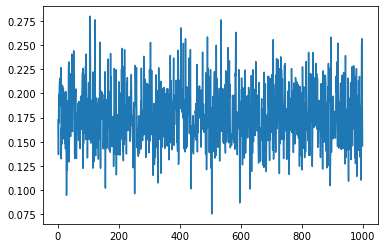

In [52]:
plot(1000,100)

### 重复1000次，每次1000个散点

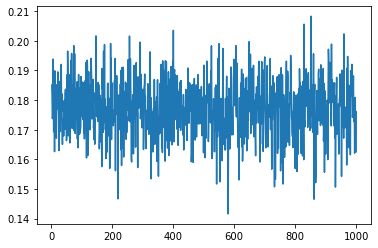

In [53]:
plot(1000, 1000)

### 重复1000次，每次10000个散点

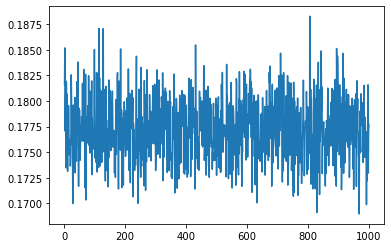

In [54]:
plot(1000, 10000)

综合上面的结果可知：随着散点数的增加，积分的波动范围变小，误差变小，符合大数定理。

## 1.2

In [55]:
import random
import numpy as np


def f(x):
    return np.exp(-100 * (x - 0.5) @ (x - 0.5).T)


def multi_integral(num):
    sum = 0
    b = 1
    a = 0
    for i in range(num):
        x = np.random.rand(9)
        sum += f(x)
    return sum / num


def plot(times, num):
    ctr = []
    int = []
    for i in range(times):
        ctr.append(i + 1)
        int.append(multi_integral(num))
    plt.plot(ctr, int)
    plt.show()
    print('integral = {}'.format(np.mean(int)))

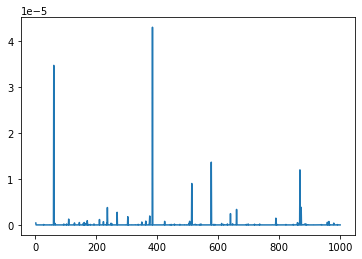

integral = 1.5750283682938318e-07


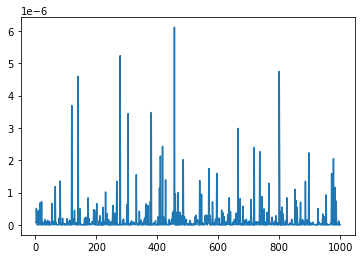

integral = 1.400362613097055e-07


In [56]:
plot(1000, 1000)
plot(1000, 10000)


# 2.
## 2.1

当我们对Potts model做一次 spin flip 的时候，系统能量的该变量只取决于这个被反转的 spin 以及它周围的四个 spins。
$$
\begin{aligned}
    E' &= -J(\delta_{s's_l}+\delta_{s's_r}+\delta_{s's_t}+\delta_{s's_b})\\
    E &= -J(\delta_{ss_l}+\delta_{ss_r}+\delta_{ss_t}+\delta_{ss_b}) \\
    \Delta E &= -J(\delta_{s's_l}+\delta_{s's_r}+\delta_{s's_t}+\delta_{s's_b}) + J(\delta_{ss_l}+\delta_{ss_r}+\delta_{ss_t}+\delta_{ss_b})\\
    &=-J(4-(\delta_{ss_l}+\delta_{ss_r}+\delta_{ss_t}+\delta_{ss_b}))+J(\delta_{ss_l}+\delta_{ss_r}+\delta_{ss_t}+\delta_{ss_b})\\
    &=-4J+2J(\delta_{ss_l}+\delta_{ss_r}+\delta_{ss_t}+\delta_{ss_b})
\end{aligned}
$$

需要注意的是，对于 Potts Model， magnetization 的公式如下：
$$
M = |\sum_{i,j} e^{2\pi\frac{s_{ij}}{q}}|
$$

### Potts model

In [57]:
import numpy as np
import random
import matplotlib.pyplot as plt
from tqdm import tqdm

class Potts():
    def __init__(self, size, J):
        self.size = size
        self.J = J
        self.lattice = np.ones((self.size, self.size),int)
        self.E = 0

    def set_initial(self):
        self.lattice = np.ones((self.size, self.size), int)
        self.E = self.totalE()

    def up(self, x, y):
        # 周期性边界条件
        if x == 0:
            return [self.size - 1, y]
        else:
            return [x - 1, y]

    def down(self, x, y):
        if x == self.size - 1:
            return [0, y]
        else:
            return [x + 1, y]

    def left(self, x, y):
        if y == 0:
            return [x, self.size - 1]
        else:
            return [x, y - 1]

    def right(self, x, y):
        if y == self.size - 1:
            return [x, 0]
        else:
            return [x, y + 1]


    def delta(self, x1, y1, x2, y2):
        if self.lattice[x1, y1] == self.lattice[x2, y2]:
            return 1
        else:
            return 0

    def totalE(self):
        E = 0
        for x in range(self.size):
            for y in range(self.size):
                xl,yl = self.left(x,y)
                xr,yr = self.right(x,y)
                xu,yu = self.up(x,y)
                xd,yd = self.down(x,y)
                E += self.delta(x, y, xl, yl) + self.delta(x, y, xr, yr) + self.delta(x, y, xu, yu) + self.delta(x, y, xd, yd)
        E = -self.J * E / 2
        return E

    def totalM(self):
        return np.abs(np.sum(2 * self.lattice - 3))

    def avgE(self):
        return self.totalE() / self.size**2

    def avgM(self):
        return self.totalM() / self.size**2

    def deltaE(self,x,y):
        xl,yl = self.left(x,y)
        xr,yr = self.right(x,y)
        xu,yu = self.up(x,y)
        xd,yd = self.down(x,y)
        deltaE = -4 * self.J + 2 * self.J * (
            self.delta(x, y, xl, yl) + self.delta(x, y, xr, yr) +
            self.delta(x, y, xu, yu) + self.delta(x, y, xd, yd))
        return deltaE

    def flip(self,temperature):
        x = random.randint(0,self.size-1)
        y = random.randint(0,self.size-1)
        deltaE = self.deltaE(x, y)
        if deltaE < 0:
            self.lattice[x,y] = 3 - self.lattice[x,y]
            self.E += deltaE

        else:
            if random.random() < np.exp(- deltaE / temperature):
                self.lattice[x, y] = 3 - self.lattice[x,y]
                self.E += deltaE

    # def equi(self, temperature, flip_num=1):
    #     for flip_time in range(flip_num):
    #         self.flip(temperature)
    #     return self.totalE(),self.totalM()

    def output(self,t1,t2,step,start:int=100000, times:int=10000):
        t = t1
        templ = []
        E = []
        M = []
        C = []
        X = []
        for i in tqdm(range(int((t2 - t1) / step + 1))):
            templ.append(t)
            E_t = []
            M_t = []
            self.set_initial()
            for i in range(start):
                self.flip(t)
            for time in range(times):
                self.flip(t)
                E_t.append(self.E)
                M_t.append(self.totalM())
            E.append(np.mean(E_t) / self.size**2)
            M.append(np.mean(M_t) / self.size**2)
            C.append((np.mean(np.array(E_t)**2) - np.mean(E_t)**2) / (self.size**2 * t**2))
            X.append((np.mean(np.array(M_t)**2) - np.mean(M_t)**2) / (self.size**2))
            t += step
        return templ,E,M,C,X

In [58]:
P = Potts(10, 1)
temp, E_10, M_10, C_10, X_10 = P.output(0.1, 4, 0.1, times=100000)
P = Potts(40, 1)
temp, E_40, M_40, C_40, X_40 = P.output(0.1, 4, 0.1, times=100000)
P = Potts(80, 1)
temp, E_80, M_80, C_80, X_80 = P.output(0.1, 4, 0.1, times=100000)

100%|██████████| 40/40 [06:25<00:00,  9.63s/it]


In [59]:
data_10 = np.c_[temp, E_10, M_10, C_10, X_10]
np.save('2_1_data_10', data_10)
data_40 = np.c_[temp, E_40, M_40, C_40, X_40]
np.save('2_1_data_40', data_40)
data_80 = np.c_[temp, E_80, M_80, C_80, X_80]
np.save('2_1_data_80', data_80)


In [60]:
data_10 = np.load('2_1_data_10.npy')
temp, E_10, M_10, C_10, X_10 = data_10[:, 0], data_10[:, 1], data_10[:, 2], data_10[:, 3], data_10[:, 4]
data_40 = np.load('2_1_data_40.npy')
temp, E_40, M_40, C_40, X_40 = data_40[:, 0], data_40[:, 1], data_40[:, 2], data_40[:, 3], data_40[:, 4]
data_80 = np.load('2_1_data_80.npy')
temp, E_80, M_80, C_80, X_80 = data_80[:, 0], data_80[:, 1], data_80[:, 2], data_80[:, 3], data_80[:, 4]


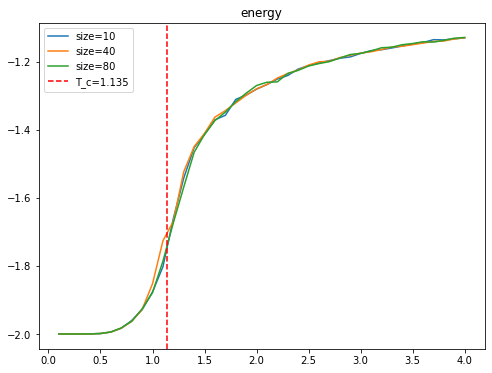

In [61]:
plt.figure(figsize=[8, 6])
plt.plot(temp, E_10, label='size=10')
plt.plot(temp, E_40, label='size=40')
plt.plot(temp, E_80, label='size=80')
plt.axvline(x=1.135, c='r', linestyle='--', label='T_c=1.135')
plt.title('energy')
plt.legend()
plt.show()

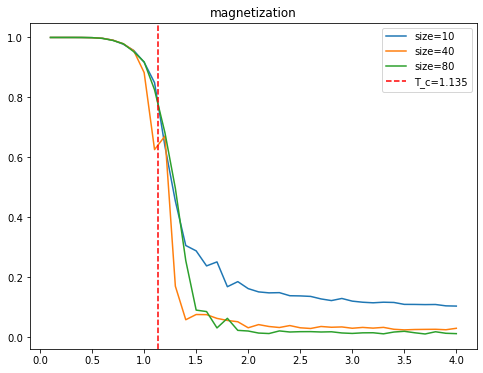

In [62]:
plt.figure(figsize=[8, 6])
plt.plot(temp, M_10, label='size=10')
plt.plot(temp, M_40, label='size=40')
plt.plot(temp, M_80, label='size=80')
plt.axvline(x=1.135, c='r', linestyle='--', label='T_c=1.135')
plt.title('magnetization')
plt.legend()
plt.show()

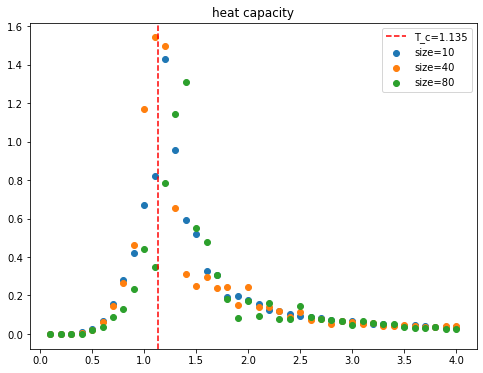

In [63]:
plt.figure(figsize=[8, 6])
plt.scatter(temp, C_10, label='size=10')
plt.scatter(temp, C_40, label='size=40')
plt.scatter(temp, C_80, label='size=80')
plt.axvline(x=1.135, c='r', linestyle='--', label='T_c=1.135')
plt.title('heat capacity')
plt.legend()
plt.show()

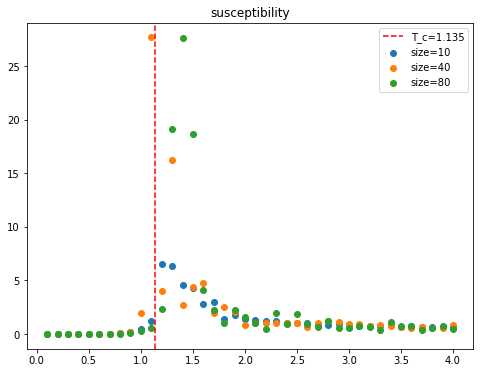

In [64]:
plt.figure(figsize=[8, 6])
plt.scatter(temp, X_10, label='size=10')
plt.scatter(temp, X_40, label='size=40')
plt.scatter(temp, X_80, label='size=80')
plt.axvline(x=1.135, c='r', linestyle='--', label='T_c=1.135')
plt.title('susceptibility')
plt.legend()
plt.show()

运行 $p=2$ 的 Potts model 程序，可以发现，热容与磁导率作为温度的函数在 $T_C\approx 1.135$ 附近不连续，发生二级相变。

## 2.2

和Potts model一样，当我们对Ising model做一次 spin flip 的时候，系统能量的该变量也只取决于这个被反转的 spin 以及它周围的四个 spins。
$$
\begin{aligned}
    E' &= -J(s's_l+s's_r+s's_t+s's_b)\\
    E &= -J(ss_l+ss_r+ss_t+ss_b) \\
    \Delta E &= -J(s's_l+s's_r+s's_t+s's_b) + J(ss_l+ss_r+ss_t+ss_b)\\
    &=J(s_l+s_r+s_t+s_b)(s-s')
\end{aligned}
$$

In [44]:
import numpy as np
import random
import matplotlib.pyplot as plt


class Ising():
    def __init__(self, size, J):
        self.size = size
        self.J = J
        self.lattice = np.ones((self.size, self.size), int)
        self.E = 0

    def set_initial(self):
        self.lattice = np.ones((self.size, self.size), int)
        self.E = self.totalE()

    def up(self, x, y):
        # 周期性边界条件
        if x == 0:
            return [self.size - 1, y]
        else:
            return [x - 1, y]

    def down(self, x, y):
        if x == self.size - 1:
            return [0, y]
        else:
            return [x + 1, y]

    def left(self, x, y):
        if y == 0:
            return [x, self.size - 1]
        else:
            return [x, y - 1]

    def right(self, x, y):
        if y == self.size - 1:
            return [x, 0]
        else:
            return [x, y + 1]

    def delta(self, x1, y1, x2, y2):
        return self.lattice[x1, y1] * self.lattice[x2, y2]

    def totalE(self):
        E = 0
        for x in range(self.size):
            for y in range(self.size):
                xl, yl = self.left(x, y)
                xr, yr = self.right(x, y)
                xu, yu = self.up(x, y)
                xd, yd = self.down(x, y)
                E += self.delta(x, y, xl, yl) + self.delta(
                    x, y, xr, yr) + self.delta(x, y, xu, yu) + self.delta(
                        x, y, xd, yd)
        E = -self.J * E / 2
        return E

    def totalM(self):
        return np.abs(np.sum(self.lattice))

    def avgE(self):
        return self.totalE() / self.size**2

    def avgM(self):
        return self.totalM() / self.size**2

    def deltaE(self, x, y):
        xl, yl = self.left(x, y)
        xr, yr = self.right(x, y)
        xu, yu = self.up(x, y)
        xd, yd = self.down(x, y)
        deltaE = self.J * (self.lattice[xl, yl] + self.lattice[xr, yr] +
                           self.lattice[xu, yu] + self.lattice[xd, yd]) * ( 2 * self.lattice[x,y])
        return deltaE

    def flip(self, temperature):
        x = random.randint(0, self.size - 1)
        y = random.randint(0, self.size - 1)
        deltaE = self.deltaE(x, y)
        if deltaE < 0:
            self.lattice[x, y] = -self.lattice[x, y]
            self.E += deltaE
        else:
            if random.random() < np.exp(-deltaE / temperature):
                self.lattice[x, y] = -self.lattice[x, y]
                self.E += deltaE

    def output(self, t1, t2, step, start: int = 100000, times: int = 1000):
        t = t1
        templ = []
        E = []
        M = []
        C = []
        X = []
        for i in tqdm(range(int((t2 - t1) / step + 1))):
            templ.append(t)
            E_t = []
            M_t = []
            self.set_initial()
            for i in range(start):
                self.flip(t)
            for time in range(times):
                self.flip(t)
                E_t.append(self.E)
                M_t.append(self.totalM())
            E.append(np.mean(E_t) / self.size**2)
            M.append(np.mean(M_t) / self.size**2)
            C.append((np.mean(np.array(E_t)**2) - np.mean(E_t)**2) /
                     (self.size**2 * t**2))
            X.append(
                (np.mean(np.array(M_t)**2) - np.mean(M_t)**2) / (self.size**2))
            t += step
        return templ, E, M, C, X


In [45]:
I = Ising(10, 1)
temp, E_10, M_10, C_10, X_10 = I.output(1, 4, 0.1, start=500000, times=500000)
I = Ising(40, 1)
temp, E_40, M_40, C_40, X_40 = I.output(1, 4, 0.1, start=500000, times=500000)
I = Ising(80, 1)
temp, E_80, M_80, C_80, X_80 = I.output(1, 4, 0.1, start=500000, times=500000)

100%|██████████| 31/31 [19:17<00:00, 37.33s/it]


In [46]:
data_10 = np.c_[temp, E_10, M_10, C_10, X_10]
np.save('2_2_data_10', data_10)
data_40 = np.c_[temp, E_40, M_40, C_40, X_40]
np.save('2_2_data_40', data_40)
data_80 = np.c_[temp, E_80, M_80, C_80, X_80]
np.save('2_2_data_80', data_80)

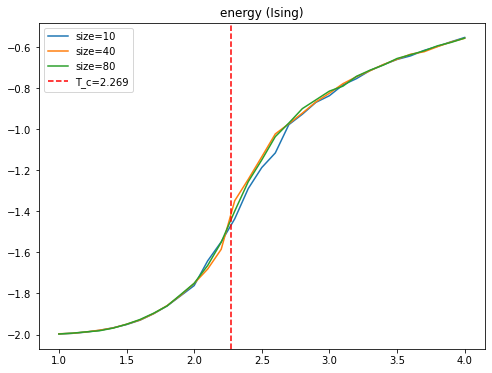

In [47]:
plt.figure(figsize=[8,6])
plt.plot(temp, E_10, label='size=10')
plt.plot(temp, E_40, label='size=40')
plt.plot(temp, E_80, label='size=80')
plt.axvline(x=2.269, c='r', linestyle='--', label='T_c=2.269')
plt.title('energy (Ising)')
plt.legend()
plt.show()

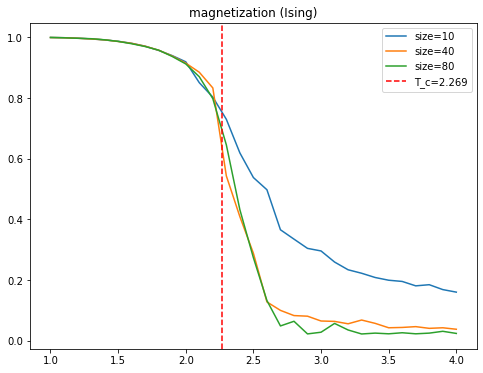

In [48]:
plt.figure(figsize=[8, 6])
plt.plot(temp, M_10, label='size=10')
plt.plot(temp, M_40, label='size=40')
plt.plot(temp, M_80, label='size=80')
plt.axvline(x=2.269, c='r', linestyle='--', label='T_c=2.269')
plt.title('magnetization (Ising)')
plt.legend()
plt.show()

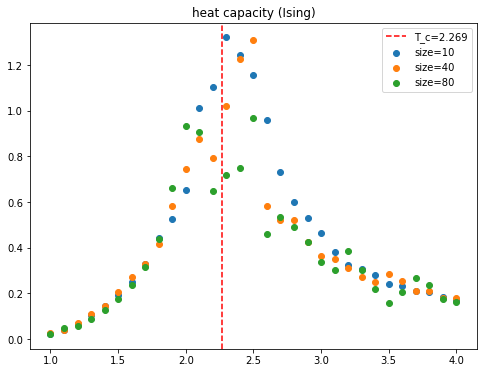

In [49]:
plt.figure(figsize=[8, 6])
plt.scatter(temp, C_10, label='size=10')
plt.scatter(temp, C_40, label='size=40')
plt.scatter(temp, C_80, label='size=80')
plt.axvline(x=2.269, c='r', linestyle='--', label='T_c=2.269')
plt.title('heat capacity (Ising)')
plt.legend()
plt.show()

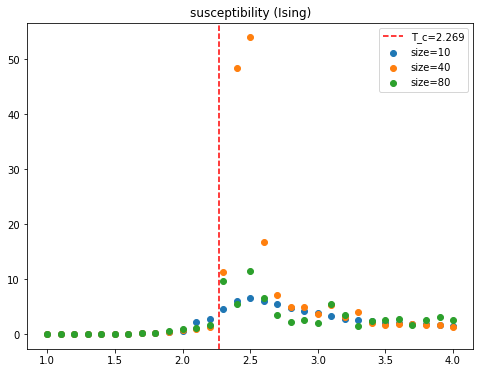

In [50]:
plt.figure(figsize=[8, 6])
plt.scatter(temp, X_10, label='size=10')
plt.scatter(temp, X_40, label='size=40')
plt.scatter(temp, X_80, label='size=80')
plt.axvline(x=2.269, c='r', linestyle='--', label='T_c=2.269')
plt.title('susceptibility (Ising)')
plt.legend()
plt.show()

运行 Ising model 程序，可以发现，热容与磁导率作为温度的函数在 $T_C\approx 2.269$ 附近不连续，发生二级相变。对比 $q=2$ 的 Potts model 可以发现，Ising model 的二级相变温度大约是 Potts model 的 2 倍。

## 2.3 q=3,6,10

当我们对Potts model做一次 spin flip 的时候，系统能量的该变量只取决于这个被反转的 spin 以及它周围的四个 spins。
$$
\begin{aligned}
    E' &= -J(\delta_{s's_l}+\delta_{s's_r}+\delta_{s's_t}+\delta_{s's_b})\\
    E &= -J(\delta_{ss_l}+\delta_{ss_r}+\delta_{ss_t}+\delta_{ss_b}) \\
    \Delta E &= -J(\delta_{s's_l}+\delta_{s's_r}+\delta_{s's_t}+\delta_{s's_b}) + J(\delta_{ss_l}+\delta_{ss_r}+\delta_{ss_t}+\delta_{ss_b})\\
    
\end{aligned}
$$

| initial |   |   |   | final |   |   |   | deltaE(-J) |
|:-------:|:-:|:-:|:-:|:-----:|:-:|:-:|:-:|:----------:|
|    1    | 1 | 1 | 1 |   0   | 0 | 0 | 0 |     -4     |
|    0    | 1 | 1 | 1 |   1   | 0 | 0 | 0 |     -2     |
|         |   |   |   |   0   | 0 | 0 | 0 |     -3     |
|    0    | 0 | 1 | 1 |   1   | 1 | 0 | 0 |      0     |
|         |   |   |   |   0   | 1 | 0 | 0 |     -1     |
|         |   |   |   |   0   | 0 | 0 | 0 |     -2     |
|    0    | 0 | 0 | 1 |   1   | 1 | 1 | 0 |      2     |
|         |   |   |   |   0   | 1 | 1 | 0 |      1     |
|         |   |   |   |   0   | 0 | 1 | 0 |      0     |
|         |   |   |   |   0   | 0 | 0 | 0 |     -1     |
|    0    | 0 | 0 | 0 |   1   | 1 | 1 | 1 |      4     |
|         |   |   |   |   0   | 1 | 1 | 1 |      3     |
|         |   |   |   |   0   | 0 | 1 | 1 |      2     |
|         |   |   |   |   0   | 0 | 0 | 1 |      1     |
|         |   |   |   |   0   | 0 | 0 | 0 |      0     |

$q=3,6,10$时，$\Delta E$上述值均可取到，即 $\pm 4J,\pm 3J,\pm 2J,\pm J,0$

In [25]:
import numpy as np
import random
import matplotlib.pyplot as plt
from tqdm import tqdm


class q_Potts():
    def __init__(self, size, J, q):
        self.size = size
        self.J = J
        self.lattice = np.ones((self.size, self.size), int)
        self.q = q
        self.E = 0

    def set_initial(self):
        self.lattice = np.ones((self.size, self.size), int)
        self.E = self.totalE()

    def up(self, x, y):
        # 周期性边界条件
        if x == 0:
            return [self.size - 1, y]
        else:
            return [x - 1, y]

    def down(self, x, y):
        if x == self.size - 1:
            return [0, y]
        else:
            return [x + 1, y]

    def left(self, x, y):
        if y == 0:
            return [x, self.size - 1]
        else:
            return [x, y - 1]

    def right(self, x, y):
        if y == self.size - 1:
            return [x, 0]
        else:
            return [x, y + 1]

    def delta(self, x1, y1, x2, y2):
        if self.lattice[x1, y1] == self.lattice[x2, y2]:
            return 1
        else:
            return 0

    def Delta(self, s1, x2, y2):
        if s1 == self.lattice[x2, y2]: return 1
        else: return 0

    def totalE(self):
        E = 0
        for x in range(self.size):
            for y in range(self.size):
                xl, yl = self.left(x, y)
                xr, yr = self.right(x, y)
                xu, yu = self.up(x, y)
                xd, yd = self.down(x, y)
                E += self.delta(x, y, xl, yl) + self.delta(
                    x, y, xr, yr) + self.delta(x, y, xu, yu) + self.delta(
                        x, y, xd, yd)
        E = -self.J * E / 2
        return E

    def totalM(self):
        return np.sqrt(
            np.sum(np.cos(2 * np.pi * self.lattice / self.q))**2 +
            np.sum(np.sin(2 * np.pi * self.lattice / self.q))**2)

    def avgE(self):
        return self.totalE() / self.size**2

    def avgM(self):
        return self.totalM() / self.size**2

    def deltaE(self, x, y, new_state):
        xl, yl = self.left(x, y)
        xr, yr = self.right(x, y)
        xu, yu = self.up(x, y)
        xd, yd = self.down(x, y)
        deltaE = -self.J * (
            self.Delta(new_state, xl, yl) + self.Delta(new_state, xr, yr) +
            self.Delta(new_state, xu, yu) +
            self.Delta(new_state, xd, yd)) + self.J * (
                self.delta(x, y, xl, yl) + self.delta(x, y, xr, yr) +
                self.delta(x, y, xu, yu) + self.delta(x, y, xd, yd))
        return deltaE

    def flip(self, temperature):
        x = random.randint(0, self.size - 1)
        y = random.randint(0, self.size - 1)
        state = self.lattice[x, y]
        new_state = random.randint(1, self.q)
        deltaE = self.deltaE(x, y, new_state)
        if deltaE < 0:
            self.lattice[x, y] = new_state
            self.E += deltaE
        else:
            if random.random() < np.exp(-deltaE / temperature):
                self.lattice[x, y] = new_state
                self.E += deltaE

    def output(self, t1, t2, step, start: int = 100000, times: int = 10000):
        t = t1
        templ = []
        E = []
        M = []
        C = []
        X = []
        for i in tqdm(range(int((t2 - t1) / step + 1))):
            templ.append(t)
            E_t = []
            M_t = []
            self.set_initial()
            for i in range(start):
                self.flip(t)
            for time in range(times):
                self.flip(t)
                E_t.append(self.E)
                M_t.append(self.totalM())
            E.append(np.mean(E_t) / self.size**2)
            M.append(np.mean(M_t) / self.size**2)
            C.append((np.mean(np.array(E_t)**2) - np.mean(E_t)**2) /
                     (self.size**2 * t**2))
            X.append(
                (np.mean(np.array(M_t)**2) - np.mean(M_t)**2) / (self.size**2))
            t += step
        return templ, E, M, C, X


In [26]:
def plot(q, E, M, C, X):
    plt.figure(figsize=[10,10])

    plt.subplot(221)
    plt.plot(temp, E, label='q=' + str(q))
    plt.title('energy')
    plt.legend()

    plt.subplot(222)
    plt.plot(temp, M, label='q=' + str(q))
    plt.title('magnetization')
    plt.legend()

    plt.subplot(223)
    plt.scatter(temp, C, label='q=' + str(q))
    plt.title('heat capacity')
    plt.legend()

    plt.subplot(224)
    plt.scatter(temp, X, label='q=' + str(q))
    plt.title('susceptibility')
    plt.legend()

    plt.show()

In [27]:
P3 = q_Potts(50, 1, 3)
temp, E, M, C, X = P3.output(0.1, 3, 0.1, times=100000)

100%|██████████| 29/29 [08:05<00:00, 16.74s/it]


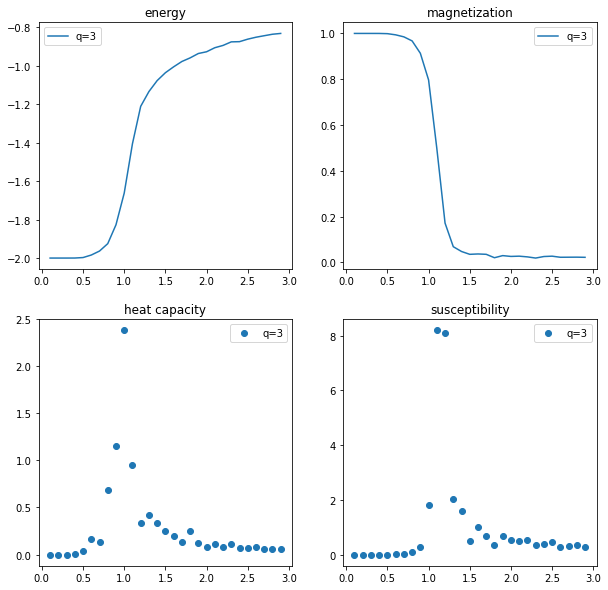

In [28]:
plot(3, E, M, C, X)

In [29]:
P6 = q_Potts(50, 1, 6)
temp, E, M, C, X = P6.output(0.1, 3, 0.1, times=100000)

100%|██████████| 29/29 [07:22<00:00, 15.27s/it]


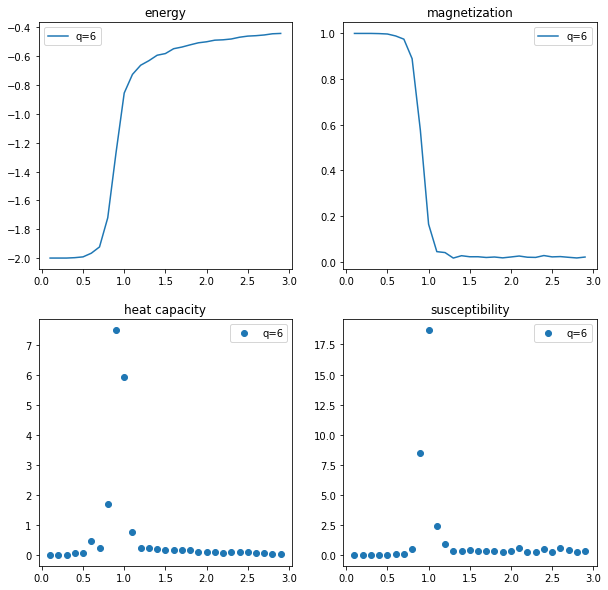

In [30]:
plot(6, E, M, C, X)

In [31]:
P10 = q_Potts(50, 1, 10)
temp, E, M, C, X = P10.output(0.1, 3, 0.1, times=100000)

100%|██████████| 29/29 [07:29<00:00, 15.52s/it]


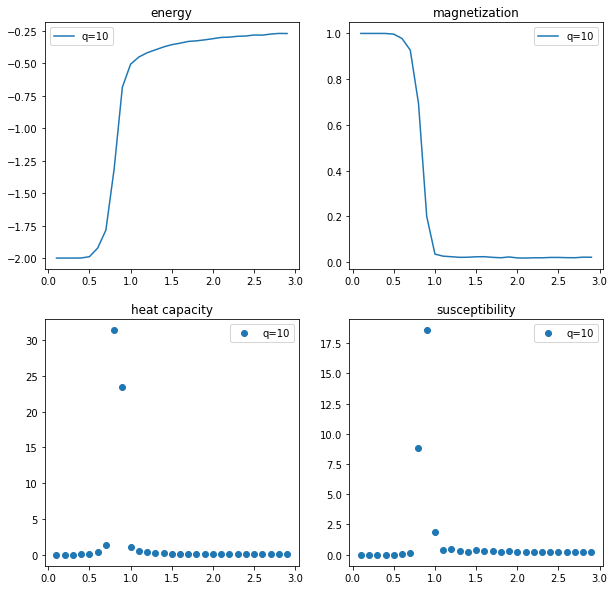

In [32]:
plot(10, E, M, C, X)

缩小温度范围

### $q=3$

In [33]:
def plot_(q, E, M, C, X):
    plt.figure(figsize=[10, 10])

    plt.subplot(221)
    plt.plot(temp, E, '.-.', label='q=' + str(q))
    plt.title('energy')
    plt.legend()

    plt.subplot(222)
    plt.plot(temp, M, '.-.', label='q=' + str(q))
    plt.title('magnetization')
    plt.legend()

    plt.subplot(223)
    plt.scatter(temp, C, label='q=' + str(q))
    plt.title('heat capacity')
    plt.legend()

    plt.subplot(224)
    plt.scatter(temp, X, label='q=' + str(q))
    plt.title('susceptibility')
    plt.legend()

    plt.show()

In [35]:
P3 = q_Potts(50, 1, 3)
temp, E, M, C, X = P3.output(0.5, 1.5, 0.05, start=500000, times=500000)

100%|██████████| 21/21 [23:57<00:00, 68.47s/it]


In [36]:
data = np.c_[temp, E, M, C, X]
np.save('2_3_q=3_data', data)

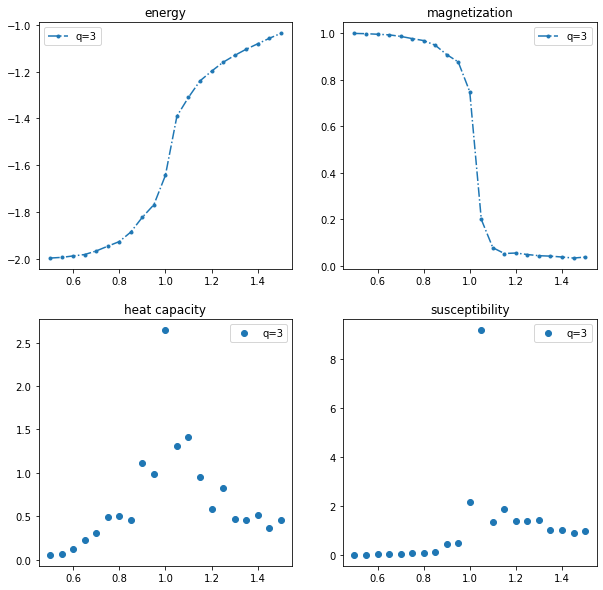

In [37]:
plot_(3, E, M, C, X)

$q=3$ 时，相变温度在$\sim 1K$

### $q=6$

In [38]:
P6 = q_Potts(50, 1, 6)
temp, E, M, C, X = P6.output(0.5, 1.5, 0.05, start=500000, times=500000)

100%|██████████| 21/21 [21:50<00:00, 62.38s/it]


In [39]:
data = np.c_[temp, E, M, C, X]
np.save('2_3_q=6_data', data)

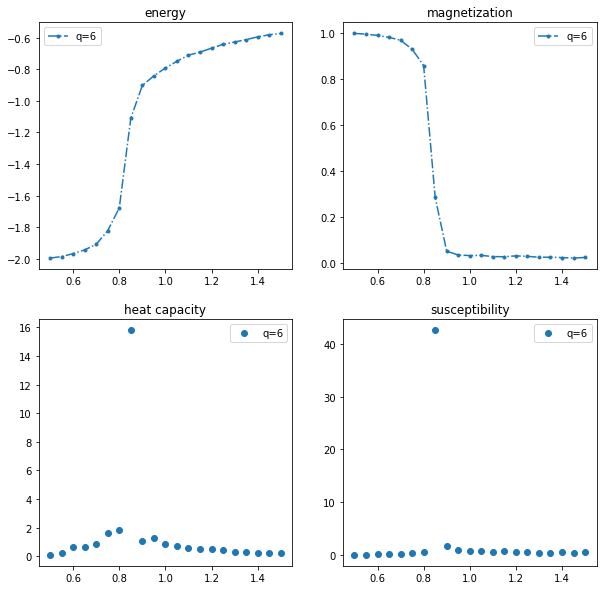

In [40]:
plot_(6, E, M, C, X)

$q=6$ 时，相变温度在$\sim 0.85K$

### $q=10$

In [41]:
P10 = q_Potts(50, 1, 10)
temp, E, M, C, X = P10.output(0.5, 1.5, 0.05, start=500000, times=500000)

100%|██████████| 21/21 [21:24<00:00, 61.15s/it]


In [42]:
data = np.c_[temp, E, M, C, X]
np.save('2_3_q=10_data', data)

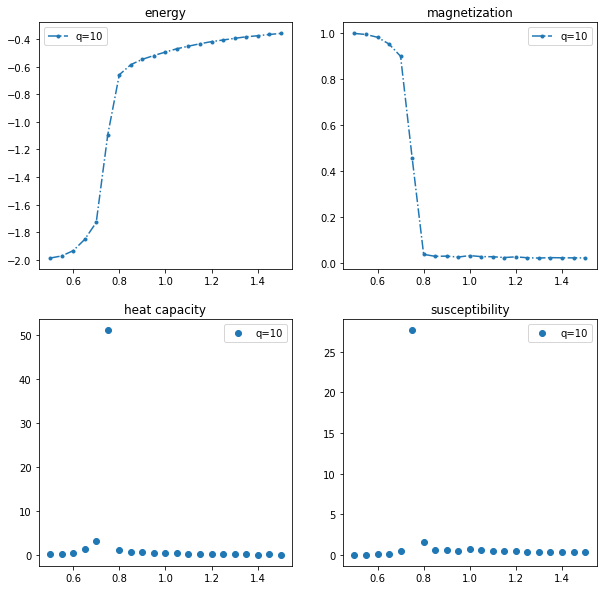

In [43]:
plot_(10, E, M, C, X)

$q=10$ 时，相变温度在$\sim 0.75K$

与 $q=2$ 相比，临界温度随 $q$ 增大而减小。且一阶相变的情况越来越明显。